Number of detected objects: 42


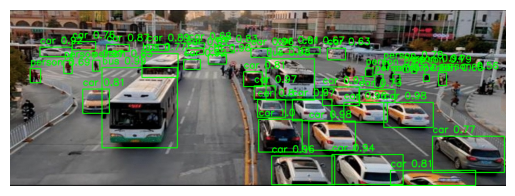

In [2]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

# Correct URLs for downloading YOLO files
cfg_url = "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"
weights_url = "https://pjreddie.com/media/files/yolov3.weights"
names_url = "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"

# Download the YOLO files
urllib.request.urlretrieve(cfg_url, 'yolov3.cfg')
urllib.request.urlretrieve(weights_url, 'yolov3.weights')
urllib.request.urlretrieve(names_url, 'coco.names')

# Load YOLO
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
layer_names = net.getLayerNames()

# Fix: Extract the output layers correctly
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load class labels
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Function to perform object detection on an image
def detect_objects(image_path):
    # Load the image
    img = cv2.imread(image_path)
    height, width, channels = img.shape

    # Resize image and prepare it for YOLO
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    # Forward pass through the network
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:  # Threshold for confidence
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maxima suppression to remove duplicate boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Count the number of detected objects
    detected_objects = len(indices)

    # Print the number of objects detected
    print(f"Number of detected objects: {detected_objects}")

    # Draw bounding boxes
    for i in range(len(boxes)):
        if i in indices:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = str(round(confidences[i], 2))

            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(img, label + " " + confidence, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the image with bounding boxes
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Turn off axis
    plt.show()

# Example: Provide the path to the image
image_path = '/content/traffic.jpg'  # Replace this with your image path
detect_objects(image_path)